# Evaluation

## In this notebook, we will be testing the clustering against several published gentrification studies. 
Each study has their own criteria for a neighborhood that has the potential to gentrify and what constitutes a gentrifying neighborhood. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
plt.style.use('seaborn')
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as hc
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from sklearn.dummy import DummyClassifier

sns.set(rc={'figure.figsize':(15,10)})
plt.style.use('fivethirtyeight')
city_infographics = ['#7297d2','#daa525', '#90bcf4', '#1b2a4d', '#fad363', '#4d6bab', '#484b54', '#676e7c', '#5b89c0', '#3c64a4']
sns.set_palette(city_infographics)

In [2]:
df = pd.read_pickle('PKL/nyc_count.pkl')
nyc = pd.read_pickle('PKL/nyc_full_pc.pkl')
nyc.head()

,TRACTID,POP10_POP00_%,NHWHT10%_NHWHT00%,NHBLK10%_NHBLK00%,NTV10%_NTV00%,ASIAN10%_ASIAN00%,HISP10%_HISP00%,HAW10%_HAW00%,INDIA10%_INDIA00%,CHINA10%_CHINA00%,FILIP10%_FILIP00%,JAPAN10%_JAPAN00%,KOREA10%_KOREA00%,VIET10%_VIET00%,MEX10%_MEX00%,PR10%_PR00%,CUBAN10%_CUBAN00%,VAC10%_VAC00%,OHU10%_OHU00%,A18UND10%_A18UND00%,A60UP10%_A60UP00%,A75UP10%_A75UP00%,AGEWHT10%_AGEWHT00%,A15WHT10%_A15WHT00%,A60WHT10%_A60WHT00%,AGEBLK10%_AGEBLK00%,A15BLK10%_A15BLK00%,A60BLK10%_A60BLK00%,AGEHSP10%_AGEHSP00%,A15HSP10%_A15HSP00%,A60HSP10%_A60HSP00%,AGENTV10%_AGENTV00%,A15NTV10%_A15NTV00%,A60NTV10%_A60NTV00%,AGEASN10%_AGEASN00%,A15ASN10%_A15ASN00%,A60ASN10%_A60ASN00%,FAMILY10%_FAMILY00%,FHH10%_FHH00%,OWN10%_OWN00%,RENT10%_RENT00%,NONWHT10%_NONWHT00%,AG15UP12%_AG15UP00%,AG18CV12%_AG18CV00%,AG25UP12%_AG25UP00%,AG5UP12%_AG5UP00%,CLF12%_CLF00%,COL12%_COL00%,DAPOV12%_DAPOV00%,DBPOV12%_DBPOV00%,DFLABF12%_DFLABF00%,DFMPOV12%_DFMPOV00%,DHPOV12%_DHPOV00%,DMULTI12_DMULTI00,DNAPOV12%_DNAPOV00%,DPOV12%_DPOV00%,DWPOV12%_DWPOV00%,EMPCLF12%_EMPCLF00%,FB12%_FB00%,FLABF12%_FLABF00%,GEANC12%_GEANC00%,GEFB12%_GEFB00%,H10YRS12%_H10YRS00%,H30OLD12%_H30OLD00%,HH12_HH00,HHA12%_HHA00%,HHB12%_HHB00%,HHH12%_HHH00%,HHW12%_HHW00%,HINC12_HINC00,HINCA12_HINCA00,HINCB12_HINCB00,HINCH12_HINCH00,HINCW12_HINCW00,HS12%_HS00%,INCPC12_INCPC00,IRANC12%_IRANC00%,IRFB12%_IRFB00%,ITANC12%_ITANC00%,ITFB12%_ITFB00%,LEP12%_LEP00%,MANUF12%_MANUF00%,MHMVAL12_MHMVAL00,MRENT12_MRENT00,MULTI12_MULTI00,Mar-12%_Mar-00%,N10IMM12%_N10IMM00%,N65POV12%_N65POV00%,NAPOV12%_NAPOV00%,NAT12%_NAT00%,NBPOV12%_NBPOV00%,NFMPOV12%_NFMPOV00%,NHPOV12%_NHPOV00%,NNAPOV12%_NNAPOV00%,NONWHT_POV12%_NONWHT_POV00%,NPOV12%_NPOV00%,NWPOV12%_NWPOV00%,OHU12%_OHU00SP%,OLANG12%_OLANG00%,PROF12%_PROF00%,RUANC12%_RUANC00%,RUFB12%_RUFB00%,SCANC12%_SCANC00%,SCFB12%_SCFB00%,SEMP12%_SEMP00%,UNEMP12%_UNEMP00%,VET12%_VET00%,WDS12%_WDS00%
1,36005000200,22.256700,-49.122660,2.573296,22.692663,348.237194,-0.644172,0.0,203.810403,1454.107060,758.848639,-18.204892,0.000000,0.000000,116.646503,-18.826570,15.475447,182.068770,193.017868,-10.197502,2.854297,31.927594,-49.122660,-66.839821,-54.953419,3.649573,-6.072603,14.172339,-0.644172,-15.543947,9.060145,63.590217,308.975542,0.000000,504.374968,2517.443470,390.770651,1.197669,3.990766,-5.905117,8.264145,0.204621,8.879956,8.484428,0.539555,1.844618,22.393365,142.097784,2506.009717,20.365903,9.247228,-14.178971,-6.365021,22.689076,181.525137,0.377138,-84.919520,21.299511,70.318700,19.610549,-100.000000,0.0,36.827888,16.872201,16.028495,0.000000,12.868612,-2.913313,-68.916624,67.493359,0.000000,17.352303,83.384483,4.320000,-31.361288,49.261727,-64.948282,0.0,16.509559,0.0,0.670111,-81.883839,151.459202,63.904494,58.588235,-21.895338,21.549184,-41.555690,0.0,88.924073,-2.953788,-17.295788,30.840936,0.0,17.929769,-10.967715,-100.000000,-3.888303,-6.325945,15.352474,0.0,0.0,0.0,0.0,-27.864742,56.251886,-30.017942,10.642324
2,36005000400,66.053108,-34.586777,11.385660,-6.321804,-10.730190,0.280476,0.0,15.129715,-19.704404,65.609667,-39.778303,-69.889151,0.000000,394.451830,-8.644667,-10.527764,257.457754,195.932358,-8.592067,12.097453,0.766998,-34.586777,-16.466678,-51.822642,11.456335,-8.862351,50.554243,0.280476,-12.027238,12.856409,10.406445,80.665092,0.000000,-15.834736,-13.013104,381.773578,3.068920,9.341070,7.709537,-14.335713,2.990737,9.687382,11.130822,14.013221,0.514230,32.594701,166.931642,-25.778401,11.295048,0.217688,10.224356,-1.157002,63.483643,0.000000,0.774707,-51.347565,37.535351,-7.871313,7.280237,-95.370193,0.0,1.064603,-27.172429,60.649475,-66.482210,18.645907,2.151813,-82.017440,94.378797,210.892422,53.750000,91.365145,43.798074,-21.978661,111.771051,-83.332694,-100.0,-79.419942,-100.0,-5.062644,-5.401775,110.485782,136.576577,32.258065,-19.371906,-8.346285,-75.960616,0.0,9.805351,-53.545514,-36.093053,-37.840080,0.0,-42.956326,-37.047944,-57.235201,-4.203994,-1.180914,89.523403,0.0,0.0,0.0,0.0,132.151767,-18.746882,-37.978389,-1.541920
3,36005001600,7.752530,-27.611909,5.88

In [3]:
df.replace(r'^\s+$', np.nan, regex=True, inplace = True)
df['HINC00'] = df['HINC00'].astype('float64')
df['MRENT00'] = df['MRENT00'].astype('float64')


In [4]:
df = df.fillna(0)

In [5]:
df['INCLVL00'] = np.where(df['HINC12'] <= (.4 * df['HINC12'].median() ), 1,0)

In [6]:
df['FINC_RAT00'] = df['HINC00'] / df['HINC00'].median()
df['FINC_RAT12'] = df['HINC12'] / df['HINC12'].median()
df['WHITE_RAT00'] = df['NHWHT00'] / df['NHWHT00'].median()
df['WHITE_RAT10'] = df['NHWHT10'] / df['NHWHT10'].median()
df['COL_RAT00'] = df['COL00'] / df['COL00'].median()
df['COL_RAT12'] = df['COL12'] / df['COL12'].median()
df['RENT_RAT00'] = df['MRENT00'] / df['MRENT00'].median()
df['RENT_RAT12'] = df['MRENT12'] / df['MRENT12'].median()


df['FINC_10'] = np.where( ( (( (df['FINC_RAT12']) - df['FINC_RAT00'])/df['FINC_RAT12']) > .1 ), 1,0)
df['WHITE_10'] = np.where( ( ((df['WHITE_RAT10'] - df['WHITE_RAT00']) / df['WHITE_RAT10'])> .1 ), 1,0)
df['COL_10'] = np.where( ( ((df['COL_RAT12'] - df['COL_RAT00'])/df['COL_RAT12']) > .1 ), 1,0)
df['RENT_10'] = np.where( ( ((df['RENT_RAT12'] - df['RENT_RAT00'])/df['RENT_RAT12']) > .1 ), 1,0)


## Using the metrics cited in the README, the metrics created will be used as actual values

In [7]:
conditions = [df['INCLVL00'].eq(1),
              df['FINC_10'].eq(1) & df['WHITE_10'].eq(1) & df['COL_10'].eq(1) & df['RENT_10'].eq(1)]

choices = ['0',
          '2']

df['ED_2016'] = np.select(conditions,choices,'1')

In [8]:
df.head()

,TRACTID,state_x,county_x,tract_x,placefp10_x,cbsa10_x,metdiv10_x,ccflag10_x,POP00SF3,RUANC00,ITANC00,GEANC00,IRANC00,SCANC00,RUFB00,ITFB00,GEFB00,IRFB00,SCFB00,FB00,NAT00,N10IMM00,AG5UP00,OLANG00,LEP00,AG25UP00,HS00,COL00,AG15UP00,Mar-00,WDS00,CLF00,UNEMP00,DFLABF00,FLABF00,EMPCLF00,PROF00,MANUF00,SEMP00,AG18CV00,VET00,CNI16U00,DIS00,DPOV00,NPOV00,N65POV00,DFMPOV00,NFMPOV00,DWPOV00,NWPOV00,DBPOV00,NBPOV00,DNAPOV00,NNAPOV00,DHPOV00,NHPOV00,DAPOV00,NAPOV00,INCPC00,HU00SP,H30OLD00,OHU00SP,H10YRS00,DMULTI00,MULTI00,HINC00,HINCW00,HINCB00,HINCH00,HINCA00,MHMVAL00,MRENT00,HH00,HHW00,HHB00,HHH00,HHA00,POP12SF3,GEANC12,IRANC12,ITANC12,RUANC12,FB12,NAT12,ITFB12,RUFB12,AG5UP12,IRFB12,GEFB12,SCANC12,N10IMM12,OLANG12,LEP12,SCFB12,AG25UP12,DFMPOV12,HH12,HINC12,HINCB12,HINCW12,HINCH12,INCPC12,AG18CV12,VET12,EMPCLF12,DPOV12,NPOV12,DBPOV12,NBPOV12,DNAPOV12,NNAPOV12,DWPOV12,NWPOV12,DHPOV12,NHPOV12,HHB12,HHW12,HHH12,HS12,COL12,CLF12,UNEMP12,DFLABF12,FLABF12,PROF12,MANUF12,SEMP12,HHA12,HINCA12,N65POV12,NFMPOV12,NAPOV12,DAPOV12,HU12,OHU12,DMULTI12,MRENT12,MHMVAL12,MULTI12,H30OLD12,H10YRS12,AG15UP12,Mar-12,WDS12,state_y,county_y,tract_y,placefp10_y,cbsa10_y,metdiv10_y,ccflag10_y,POP00,NHWHT00,NHBLK00,NTV00,ASIAN00,HISP00,HAW00,INDIA00,CHINA00,FILIP00,JAPAN00,KOREA00,VIET00,MEX00,PR00,CUBAN00,HU00,VAC00,OHU00,A18UND00,A60UP00,A75UP00,AGEWHT00,A15WHT00,A60WHT00,AGEBLK00,A15BLK00,A60BLK00,AGEHSP00,A15HSP00,A60HSP00,AGENTV00,A15NTV00,A60NTV00,AGEASN00,A15ASN00,A60ASN00,FAMILY00,FHH00,OWN00,RENT00,GlobD00,GlobG00,STATE,COUNTY,TRACT,POP10,NHWHT10,NHBLK10,NTV10,ASIAN10,HISP10,HAW10,INDIA10,CHINA10,FILIP10,JAPAN10,KOREA10,VIET10,MEX10,PR10,CUBAN10,FAMILY10,FHH10,HU10,VAC10,OHU10,OWN10,RENT10,A18UND10,A60UP10,A75UP10,AGEWHT10,A15WHT10,A60WHT10,AGEBLK10,A15BLK10,A60BLK10,AGEHSP10,A15HSP10,A60HSP10,AGEASN10,A15ASN10,A60ASN10,AGENTV10,A15NTV10,A60NTV10,GLOBD10,GLOBG10,INCLVL00,FINC_RAT00,FINC_RAT12,WHITE_RAT00,WHITE_RAT10,COL_RAT00,COL_RAT12,RENT_RAT00,RENT_RAT12,FINC_10,WHITE_10,COL_10,RENT_10,ED_2016
0,36005000100,NY,Bronx County,Census Tract 1,51000,35620,35644,1,12780.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12780.0,3384.0,161.0,9228.0,8012.0,0.0,12780.0,6963.0,1808.0,0.0,0.0,1351.0,0.0,0.0,0.0,0.0,0.0,12284.0,504.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10721.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0,0,0,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,9741,48,92,98,49,1545,386,0,34,9741,6,12,0,1116,3379,806,0,6215,0,0,-999,-999,-999,-999,4484,9146,129,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5348,127,0,0,920,0,0,0,0,0,-999.0,0,0,0,0,0,0,0,-999,-999,0,0,0,9741,1225,301,NY,Bronx County,Census Tract 1,51000,35620,35644,1,12780.0,1091.0,7747.0,17.0,64.0,3443.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,29.0,97.0,2.0,0.0,0.0,0.0,481.0,125.0,22.0,1091.0,0.0,33.0,7741.0,1.0,52.0,3443.0,0.0,35.0,17.0,0.0,0.0,55.0,0.0,1.0,0.0,0.0,0.0,0.0,bh,Minority,NY,Bronx County,Census Tract 1,11091,782,6208,26,39,3779,0,7,3,0,0,0,0,264,353,35,0,0,0,0,0,0,0,367,157,5,782,0,21,6206,0,69,3779,0,60,39,0,1,25,0,0,bh,Minority,1,0.000000,-0.019468,1.715409,1.309883,0.000000,0.244231,0.000000,-0.911496,1,0,1,1,1
1,36005000200,NY,Bronx County,Census Tract 2,51000,35620,35644,1,3602.0,0.0,32.0,47.0,89.0,0.0,0.0,0.0,0.0,0.0,0.0,541.0,323.0,159.0,3282.0,2133.0,260.0,2116.0,1430.0,176.0,2673.0,1245.0,447.0,1492.0,112.0,1363.0,743.0,1380.0,374.0,63.0,154.0,2506.0,162.0,2268.0,576.0,3568.0,723.0,69.0,899.0,138.0,111.0,21.0,952.0,167.0,10.0,0.0,2515.0,403.0,8.0,0.0,15306.000000,1190.0,832.0,1105.0,558.0,1190.0,425.0,42539.0000,26875,65438,39427,0,167900,712.000000,1123.0,61.0,323.0,759.0,0.0,4734,0,41,49,0,1211,802,0,0,4393,0,0,0,254,2626,344,0,2796,1014,1303,71250,76793,28036,72303,22846,3573,149,2200,4707,846,1506,213,37,10,22,0,3095,693,423,22,855,1290,560,2400,230,1957,1168,567,15,146,60,46667.0,53,150,0,274,1460,1303,1460,1167,422200,674,1193,836,3825,1278,650,NY,Bronx County,Census Tract 2,51000,35620,35644,1,3545.0,209.0,807.0,8.0,25.0,2464.0,0.0,21.0,1.0,2.0,4.0,0.0,0.0,37.0,1842.0,17.

In [9]:
nyc = nyc.merge(df, on='TRACTID', how = 'left')

In [10]:
conditions = [nyc['ED_2016'].eq('1'),
              nyc['ED_2016'].eq('2'),
              nyc['ED_2016'].eq('0')]
choices = ['Stable','Gentrifying','Susceptible']
nyc['cluster'] = np.select(conditions,choices)
nyc = nyc[['cluster']]

In [11]:
from shapely.geometry import Point,Polygon
import geopandas as gpd
import descartes

In [12]:
bx_g = gpd.read_file('DATA/GeoData/bronx_geodata/tl_2010_36005_tract10.shp')
bk_g = gpd.read_file('DATA/GeoData/brooklyn_geodata/tl_2010_36047_tract10.shp')
mh_g = gpd.read_file('DATA/GeoData/manhattan_geodata/tl_2010_36061_tract10.shp')
qn_g = gpd.read_file('DATA/GeoData/queens_geodata/tl_2010_36081_tract10.shp')


bx_g.rename(columns={'GEOID10':'TRACTID'},inplace=True)
bk_g.rename(columns={'GEOID10':'TRACTID'},inplace=True)
mh_g.rename(columns={'GEOID10':'TRACTID'},inplace=True)
qn_g.rename(columns={'GEOID10':'TRACTID'},inplace=True)

In [13]:
bk_g.head(1)

,STATEFP10,COUNTYFP10,TRACTCE10,TRACTID,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,36,047,031500,36047031500,315,Census Tract 315,G5020,S,179759,0,+40.6769054,-073.9499241,"POLYGON ((-73.94709 40.67656, -73.94715 40.675..."


In [14]:
nyc.head()

,TRACTID,POP10_POP00_%,NHWHT10%_NHWHT00%,NHBLK10%_NHBLK00%,NTV10%_NTV00%,ASIAN10%_ASIAN00%,HISP10%_HISP00%,HAW10%_HAW00%,INDIA10%_INDIA00%,CHINA10%_CHINA00%,FILIP10%_FILIP00%,JAPAN10%_JAPAN00%,KOREA10%_KOREA00%,VIET10%_VIET00%,MEX10%_MEX00%,PR10%_PR00%,CUBAN10%_CUBAN00%,VAC10%_VAC00%,OHU10%_OHU00%,A18UND10%_A18UND00%,A60UP10%_A60UP00%,A75UP10%_A75UP00%,AGEWHT10%_AGEWHT00%,A15WHT10%_A15WHT00%,A60WHT10%_A60WHT00%,AGEBLK10%_AGEBLK00%,A15BLK10%_A15BLK00%,A60BLK10%_A60BLK00%,AGEHSP10%_AGEHSP00%,A15HSP10%_A15HSP00%,A60HSP10%_A60HSP00%,AGENTV10%_AGENTV00%,A15NTV10%_A15NTV00%,A60NTV10%_A60NTV00%,AGEASN10%_AGEASN00%,A15ASN10%_A15ASN00%,A60ASN10%_A60ASN00%,FAMILY10%_FAMILY00%,FHH10%_FHH00%,OWN10%_OWN00%,RENT10%_RENT00%,NONWHT10%_NONWHT00%,AG15UP12%_AG15UP00%,AG18CV12%_AG18CV00%,AG25UP12%_AG25UP00%,AG5UP12%_AG5UP00%,CLF12%_CLF00%,COL12%_COL00%,DAPOV12%_DAPOV00%,DBPOV12%_DBPOV00%,DFLABF12%_DFLABF00%,DFMPOV12%_DFMPOV00%,DHPOV12%_DHPOV00%,DMULTI12_DMULTI00,DNAPOV12%_DNAPOV00%,DPOV12%_DPOV00%,DWPOV12%_DWPOV00%,EMPCLF12%_EMPCLF00%,FB12%_FB00%,FLABF12%_FLABF00%,GEANC12%_GEANC00%,GEFB12%_GEFB00%,H10YRS12%_H10YRS00%,H30OLD12%_H30OLD00%,HH12_HH00,HHA12%_HHA00%,HHB12%_HHB00%,HHH12%_HHH00%,HHW12%_HHW00%,HINC12_HINC00,HINCA12_HINCA00,HINCB12_HINCB00,HINCH12_HINCH00,HINCW12_HINCW00,HS12%_HS00%,INCPC12_INCPC00,IRANC12%_IRANC00%,IRFB12%_IRFB00%,ITANC12%_ITANC00%,ITFB12%_ITFB00%,LEP12%_LEP00%,MANUF12%_MANUF00%,MHMVAL12_MHMVAL00,MRENT12_MRENT00,MULTI12_MULTI00,Mar-12%_Mar-00%,N10IMM12%_N10IMM00%,N65POV12%_N65POV00%,NAPOV12%_NAPOV00%,NAT12%_NAT00%,NBPOV12%_NBPOV00%,NFMPOV12%_NFMPOV00%,NHPOV12%_NHPOV00%,NNAPOV12%_NNAPOV00%,NONWHT_POV12%_NONWHT_POV00%,NPOV12%_NPOV00%,NWPOV12%_NWPOV00%,OHU12%_OHU00SP%,OLANG12%_OLANG00%,PROF12%_PROF00%,RUANC12%_RUANC00%,RUFB12%_RUFB00%,SCANC12%_SCANC00%,SCFB12%_SCFB00%,SEMP12%_SEMP00%,UNEMP12%_UNEMP00%,VET12%_VET00%,WDS12%_WDS00%,state_x,county_x,tract_x,placefp10_x,cbsa10_x,metdiv10_x,ccflag10_x,POP00SF3,RUANC00,ITANC00,GEANC00,IRANC00,SCANC00,RUFB00,ITFB00,GEFB00,IRFB00,SCFB00,FB00,NAT00,N10IMM00,AG5UP00,OLANG00,LEP00,AG25UP00,HS00,COL00,AG15UP00,Mar-00,WDS00,CLF00,UNEMP00,DFLABF00,FLABF00,EMPCLF00,PROF00,MANUF00,SEMP00,AG18CV00,VET00,CNI16U00,DIS00,DPOV00,NPOV00,N65POV00,DFMPOV00,NFMPOV00,DWPOV00,NWPOV00,DBPOV00,NBPOV00,DNAPOV00,NNAPOV00,DHPOV00,NHPOV00,DAPOV00,NAPOV00,INCPC00,HU00SP,H30OLD00,OHU00SP,H10YRS00,DMULTI00,MULTI00,HINC00,HINCW00,HINCB00,HINCH00,HINCA00,MHMVAL00,MRENT00,HH00,HHW00,HHB00,HHH00,HHA00,POP12SF3,GEANC12,IRANC12,ITANC12,RUANC12,FB12,NAT12,ITFB12,RUFB12,AG5UP12,IRFB12,GEFB12,SCANC12,N10IMM12,OLANG12,LEP12,SCFB12,AG25UP12,DFMPOV12,HH12,HINC12,HINCB12,HINCW12,HINCH12,INCPC12,AG18CV12,VET12,EMPCLF12,DPOV12,NPOV12,DBPOV12,NBPOV12,DNAPOV12,NNAPOV12,DWPOV12,NWPOV12,DHPOV12,NHPOV12,HHB12,HHW12,HHH12,HS12,COL12,CLF12,UNEMP12,DFLABF12,FLABF12,PROF12,MANUF12,SEMP12,HHA12,HINCA12,N65POV12,NFMPOV12,NAPOV12,DAPOV12,HU12,OHU12,DMULTI12,MRENT12,MHMVAL12,MULTI12,H30OLD12,H10YRS12,AG15UP12,Mar-12,WDS12,state_y,county_y,tract_y,placefp10_y,cbsa10_y,metdiv10_y,ccflag10_y,POP00,NHWHT00,NHBLK00,NTV00,ASIAN00,HISP00,HAW00,INDIA00,CHINA00,FILIP00,JAPAN00,KOREA00,VIET00,MEX00,PR00,CUBAN00,HU00,VAC00,OHU00,A18UND00,A60UP00,A75UP00,AGEWHT00,A15WHT00,A60WHT00,AGEBLK00,A15BLK00,A60BLK00,AGEHSP00,A15HSP00,A60HSP00,AGENTV00,A15NTV00,A60NTV00,AGEASN00,A15ASN00,A60ASN00,FAMILY00,FHH00,OWN00,RENT00,GlobD00,GlobG00,STATE,COUNTY,TRACT,POP10,NHWHT10,NHBLK10,NTV10,ASIAN10,HISP10,HAW10,INDIA10,CHINA10,FILIP10,JAPAN10,KOREA10,VIET10,MEX10,PR10,CUBAN10,FAMILY10,FHH10,HU10,VAC10,OHU10,OWN10,RENT10,A18UND10,A60UP10,A75UP10,AGEWHT10,A15WHT10,A60WHT10,AGEBLK10,A15BLK10,A60BLK10,AGEHSP10,A15HSP10,A60HSP10,AGEASN10,A15ASN10,A60ASN10,AGENTV10,A15NTV10,A60NTV10,GLOBD10,GLOBG10,INCLVL00,FINC_RAT00,FINC_RAT12,WHITE_RAT00,WHITE_RAT10,COL_RAT00,COL_RAT12,RENT_RAT00,RENT_RAT12,FINC_10,WHITE_10,COL_10,RENT_10,ED_2016,cluster
0,36005000200,22.256700,-49.122660,2.573296,22.692663,348.237194,-0.644172,0.0,203.810403,1454.107060,758.848639,-18.204892,0.000000

In [15]:
bk_g.rename(columns={'GEOID10':'TRACTID'},inplace=True)
bk_g['TRACTID'] = bk_g['TRACTID'].astype('str')
bx_g.rename(columns={'GEOID10':'TRACTID'},inplace=True)
bx_g['TRACTID'] = bx_g['TRACTID'].astype('str')
mh_g.rename(columns={'GEOID10':'TRACTID'},inplace=True)
mh_g['TRACTID'] = mh_g['TRACTID'].astype('str')
qn_g.rename(columns={'GEOID10':'TRACTID'},inplace=True)
qn_g['TRACTID'] = qn_g['TRACTID'].astype('str')

In [16]:
bk_g = bk_g.merge(nyc, on='TRACTID', how = 'left')
bx_g = bx_g.merge(nyc, on='TRACTID', how = 'left')
mh_g = mh_g.merge(nyc, on='TRACTID', how = 'left')
qn_g = qn_g.merge(nyc, on='TRACTID', how = 'left')

bx_g = bx_g[['TRACTID','geometry','cluster']]
bk_g = bk_g[['TRACTID','geometry','cluster']]
mh_g = mh_g[['TRACTID','geometry','cluster']]
qn_g = qn_g[['TRACTID','geometry','cluster']]

In [17]:
bk_g = bk_g[['TRACTID','geometry','cluster']]

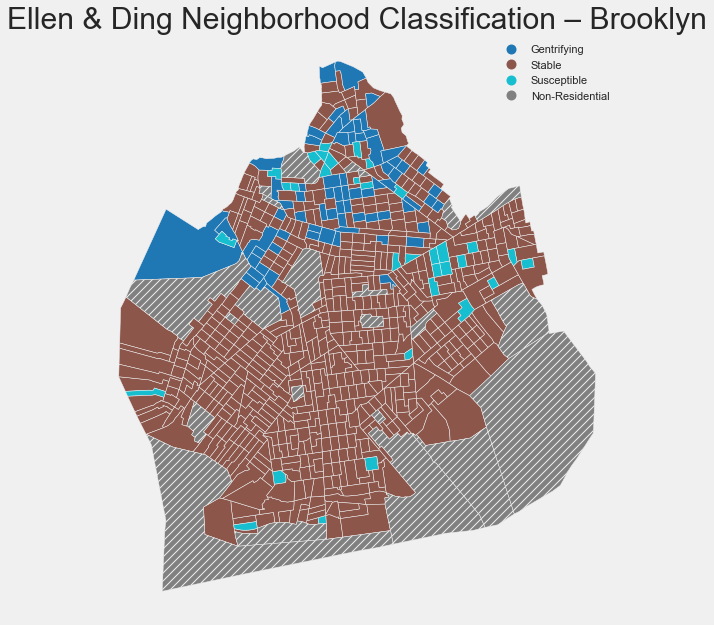

In [18]:
fig, ax = plt.subplots(figsize = (15,10))

bk_g.plot(column = 'cluster', ax = ax,legend = True, missing_kwds = {'color': 'grey', "label": "Non-Residential","hatch": "///"})
          
ax.set_title('Ellen & Ding Neighborhood Classification – Brooklyn',fontdict = {'fontsize': 30})
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('Images/ellen_ding_brooklyn.png', dpi=300, bbox_inches= 'tight', 
            padding_inches = 4, transparent = True )

[]

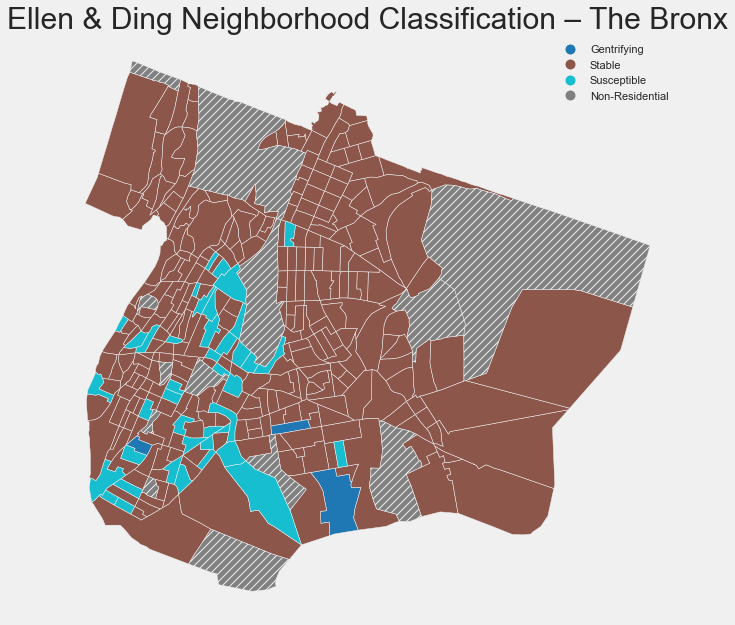

In [20]:
fig, ax = plt.subplots(figsize = (15,10))

bx_g.plot(column = 'cluster', ax = ax,legend = True, missing_kwds = {'color': 'grey', "label": "Non-Residential","hatch": "///"})
          
ax.set_title('Ellen & Ding Neighborhood Classification – The Bronx',fontdict = {'fontsize': 30})
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
#plt.savefig('Images/ellen_ding_bronx.png', dpi=300, bbox_inches= 'tight', 
#            padding_inches = 4, transparent = True )

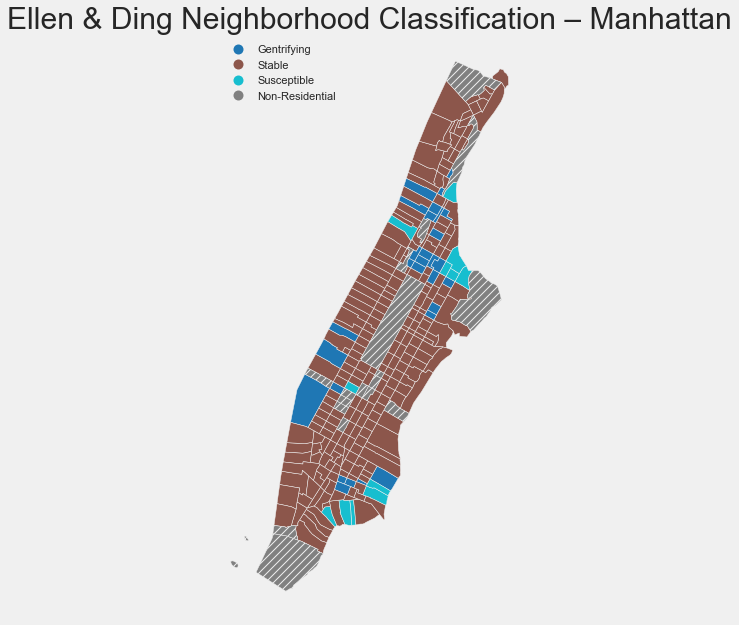

In [21]:
fig, ax = plt.subplots(figsize = (15,10))

mh_g.plot(column = 'cluster', ax = ax,legend = True, 
          missing_kwds = {'color': 'grey', "label": "Non-Residential","hatch": "///"},
         legend_kwds={'loc': 'upper left'})
          
ax.set_title('Ellen & Ding Neighborhood Classification – Manhattan',fontdict = {'fontsize': 30})
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('Images/ellen_ding_manhattan.png', dpi=300, bbox_inches= 'tight', 
            padding_inches = 4, transparent = True )

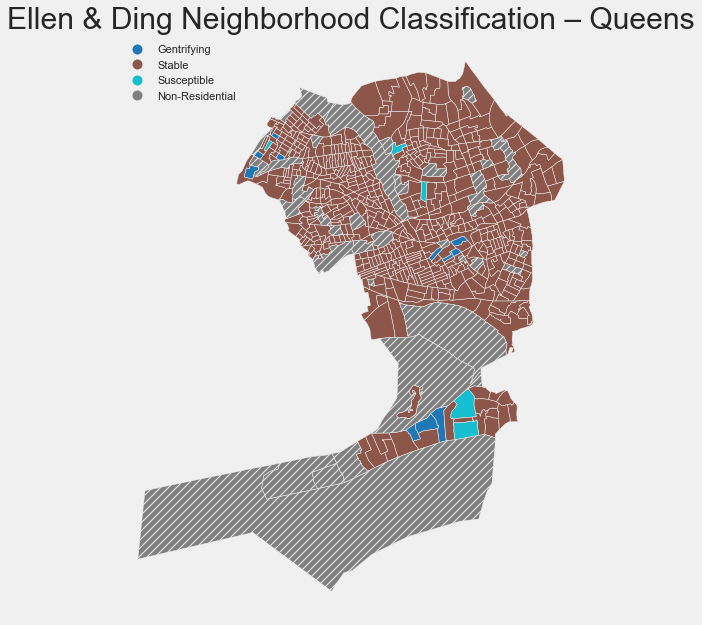

In [22]:
fig, ax = plt.subplots(figsize = (15,10))

qn_g.plot(column = 'cluster', ax = ax,legend = True, 
          missing_kwds = {'color': 'grey', "label": "Non-Residential","hatch": "///"},
         legend_kwds={'loc': 'upper left'})
          
ax.set_title('Ellen & Ding Neighborhood Classification – Queens',fontdict = {'fontsize': 30})
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('Images/ellen_ding_queens.png', dpi=300, bbox_inches= 'tight', 
            padding_inches = 4, transparent = True )